In [1]:
#analytics
import pandas as pd
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from entropy.entropy import *


# visuals
import matplotlib.pyplot as plt

## Import Condition Data

In [2]:
path = "data/useful/epilepsy/"

In [3]:
#condition = [pd.read_csv(f,header=0, index_col=0, parse_dates=True, squeeze=True) for f in glob.glob("data/Condition/*.txt")]

condition = [np.loadtxt(f) for f in glob.glob(path + "data/Condition/*.txt")]
control_open = [np.loadtxt(f) for f in glob.glob(path + "data/Control/*.txt")]
control_closed = [np.loadtxt(f) for f in glob.glob(path + "data/Control1/*.txt")]
control_epi = [np.loadtxt(f) for f in glob.glob(path + "data/Control2/*.TXT")]
control_hippo = [np.loadtxt(f) for f in glob.glob(path + "data/Control3/*.txt")]



## Import Control Data

## Display Individual Condition

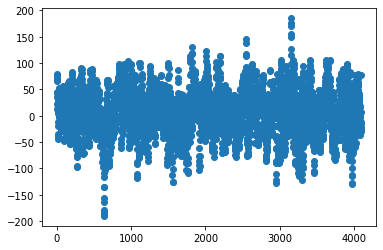

In [4]:
x_range = np.asarray([x for x in range(0,len(control_open[0]))])


plt.scatter(x_range,control_open[0])

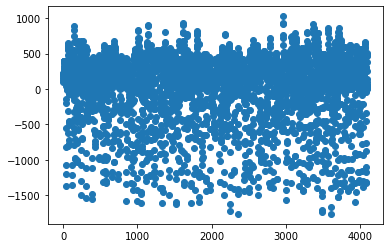

In [5]:
x_range = np.asarray([x for x in range(0,len(condition[0]))])


plt.scatter(x_range,condition[0])

## Histogram of Control and Condition Averages

In [6]:
control_open_mean = [np.mean(x) for x in control_open]
control_closed_mean = [np.mean(x) for x in control_closed]
condition_mean = [np.mean(x) for x in condition]



(array([ 7., 15.,  0.,  5., 13., 29., 25.,  0.,  0.,  6.]),
 array([-76.29411765, -62.98525751, -49.67639736, -36.36753722,
        -23.05867708,  -9.74981694,   3.5590432 ,  16.86790334,
         30.17676349,  43.48562363,  56.79448377]),
 <a list of 10 Patch objects>)

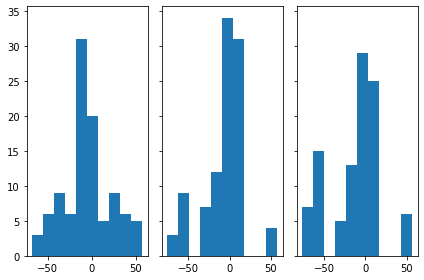

In [7]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg

axs[0].hist(condition_mean, bins=10)
axs[1].hist(control_open_mean, bins=10)
axs[2].hist(control_closed_mean, bins=10)

## Extract Features

### Extracting the following features from selected data

<ol>
<li>Mean Activity Level</li>
<li>Standard Deviation</li>
<li> Trimmed Mean </li>
</ol>

In [8]:
training_data_raw = condition + control_open + control_closed + control_hippo + control_epi

len(training_data_raw)

500

In [9]:
def normalise(X):
    return [(x - min(X))/(max(X)-min(X)) for x in X]

In [10]:
from scipy.stats import trim_mean
    
df_features = pd.DataFrame()
df_features['normalised_training_mean'] = normalise([np.mean(x) for x in training_data_raw])
df_features['normalised_training_std'] = normalise([np.std(x) for x in training_data_raw])

df_features['perm_entropy'] = normalise([perm_entropy(x,10) for x in training_data_raw])
df_features['sample_entropy'] = normalise([sample_entropy(x,2) for x in training_data_raw])
df_features['app_entropy'] = normalise([app_entropy(x,2) for x in training_data_raw])
df_features['svd_entropy'] = normalise([svd_entropy(x,3) for x in training_data_raw])
df_features['spectral_entropy'] = normalise([spectral_entropy(x,100) for x in training_data_raw])

In [11]:
feature_combinations = []

feature_names = ['perm', 'sample', 'app', 'svd','spectral']
# singles
feature_combinations.append(df_features.drop(['sample_entropy', 'app_entropy', 'svd_entropy', 'spectral_entropy'],axis=1).values)
feature_combinations.append(df_features.drop(['perm_entropy', 'app_entropy', 'svd_entropy', 'spectral_entropy'],axis=1).values)
feature_combinations.append(df_features.drop(['perm_entropy', 'sample_entropy', 'svd_entropy', 'spectral_entropy'],axis=1).values)
feature_combinations.append(df_features.drop(['perm_entropy', 'sample_entropy', 'app_entropy', 'spectral_entropy'],axis=1).values)
feature_combinations.append(df_features.drop(['perm_entropy', 'sample_entropy', 'app_entropy', 'svd_entropy'],axis=1).values)




In [12]:
y = np.asarray([1 for x in range(0,100)] + [0 for x in range(0,100)] + [2 for x in range(0,100)] + [3 for x in range(0,100)] + [4 for x in range(0,100)])


## Naive Bayes

In [13]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
accuracy_scores = []
f1_scores = []

for X in feature_combinations:
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy'))
    f1_scores.append(cross_val_score(clf, X, y, cv=10, scoring='f1_weighted'))

In [14]:
len(accuracy_scores)

5

In [15]:
print(np.mean(accuracy_scores,axis=1))



[0.516 0.578 0.578 0.638 0.578]


1: perm
2: sample
3: app
4: svd
5: spectral


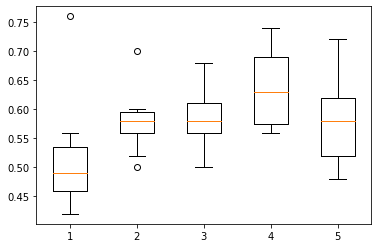

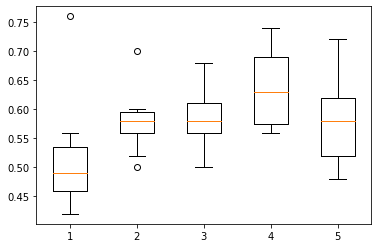

In [16]:
## Accuracy Plot
from matplotlib.pyplot import boxplot

box_plot = plt.subplots(1,1)
box_fig, box_ax = box_plot
box_ax.boxplot(accuracy_scores)
#box_ax.set_xticklabels(feature_names)

for x in range(1,len(feature_names)+1):
    
    print(str(x) + ': '+  str(feature_names[x - 1]))
    
box_fig
    

## Testing for Stationarity

In [17]:
import random

random_sample = random.sample(training_data_raw, 10)

In [18]:
from statsmodels.tsa.stattools import adfuller
mean_adf = []

for X in random_sample:
    result = adfuller(X)
    mean_adf.append(result[0])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
print("adf_mean is: ")
print(np.mean(mean_adf))

ADF Statistic: -8.641366
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
ADF Statistic: -11.180528
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
ADF Statistic: -12.477672
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
ADF Statistic: -10.118156
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
ADF Statistic: -7.903665
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
ADF Statistic: -8.812441
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
ADF Statistic: -8.020345
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
ADF Statistic: -8.474143
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
ADF Statistic: -7.998706
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
ADF Statistic: -7.180961
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
adf_mean is: 
-9.0807982899

In [19]:
for X in random_sample:
    split = round(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))

mean1=-2.711914, mean2=-3.660810
variance1=3196.547866, variance2=4047.443271
mean1=-28.418945, mean2=-28.193265
variance1=1087.274680, variance2=972.267187
mean1=53.761719, mean2=41.356271
variance1=31843.836777, variance2=39364.973120
mean1=-4.934570, mean2=-3.990727
variance1=1164.775992, variance2=1063.349353
mean1=-3.139160, mean2=-0.967789
variance1=2276.888349, variance2=3139.058016
mean1=-9.589844, mean2=-13.184480
variance1=9672.888412, variance2=12463.064064
mean1=-2.772461, mean2=-0.324549
variance1=2389.111312, variance2=1843.793643
mean1=-27.487305, mean2=-27.738897
variance1=3116.851401, variance2=2927.847394
mean1=1.510742, mean2=3.039043
variance1=1406.085822, variance2=1447.350355
mean1=-51.791504, mean2=-50.725232
variance1=897.034166, variance2=899.099222


### Test for Auto_Correlation

In [20]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS


def dw(data):
    ols_res = OLS(data, np.ones(len(data))).fit()
    return durbin_watson(ols_res.resid)



In [21]:
mean = []
for X in random_sample:
    print(dw(X))
    mean.append(dw(X))

print("mean is: ")
print(np.mean(mean))

0.2218783542359294
0.06111117963060841
0.0630539537828895
0.05252611811562879
0.10608237980811382
0.031190608296189637
0.196979689492983
0.12822632002938464
0.18251144901271182
0.13725169223062686
mean is: 
0.11808117446350659


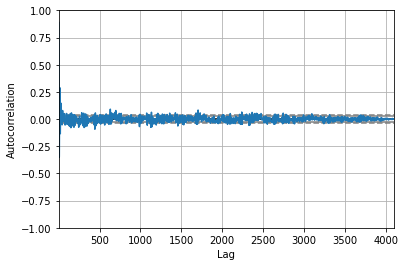

In [22]:
from pandas.plotting import autocorrelation_plot

my_plot = autocorrelation_plot(random_sample[0])

plt.show()

In [23]:
## Extract "Motif Entropy"

In [24]:
def new_discord_entropy(matrix_profile, window_size):
    # size of time_series
    time_series_size = len(matrix_profile)
    
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    
    top_discords = df_matrix_profile.sort_values(by='distances')[0:10]

    #top 10 discords
    top_discord_windows = []
    for x in top_discords['index']:
        window = np.arange(x,x+window_size,1)
        top_discord_windows.append(window)
    overall_discord_window = set(np.concatenate(top_discord_windows))
    discord_size = len(overall_discord_window)
    discord_probability = discord_size/time_series_size


    discord_entropy = -(discord_probability * np.log2(discord_probability))
    
    return discord_entropy
    

In [25]:
def new_motif_entropy(matrix_profile, window_size):
    # size of time_series
    time_series_size = len(matrix_profile)
    
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    
    top_motifs = df_matrix_profile.sort_values(by='distances')[0:10]

    # top 10 motifs 
    top_motif_windows = []
    for x in top_motifs['index']:
        window = np.arange(x,x+window_size,1)
        top_motif_windows.append(window)
    overall_motif_window = set(np.concatenate(top_motif_windows))
    motif_size = len(overall_motif_window)
    motif_probability = motif_size/time_series_size

    motif_entropy = -(motif_probability * np.log2(motif_probability))
    
    return motif_entropy

In [26]:
def motif_entropy(matrix_profile):
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    df_matrix_profile['index_left'] = matrix_profile[:,2]
    df_matrix_profile['index_right'] = matrix_profile[:,3]
    
    top_motifs = df_matrix_profile.sort_values(by='distances')[0:100]
    entropy_motif = np.sum(np.asarray([x * np.log2(x) for x in top_motifs['distances']]))
    
    return entropy_motif

In [27]:
def discord_entropy(matrix_profile):
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    df_matrix_profile['index_left'] = matrix_profile[:,2]
    df_matrix_profile['index_right'] = matrix_profile[:,3]
    
    top_discords = df_matrix_profile.sort_values(by='distances')[len(df_matrix_profile)-200:len(df_matrix_profile)] 
    entropy_discord = np.sum(np.asarray([x * np.log2(x) for x in top_discords['distances']]))
    
    return entropy_discord

In [28]:
def distance_entropy(matrix_profile):
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    df_matrix_profile['index_left'] = matrix_profile[:,2]
    df_matrix_profile['index_right'] = matrix_profile[:,3]
    
    max_discord = max(df_matrix_profile['distances'])
    entropy_distance = np.sum(np.asarray([-np.multiply((x/max_discord), np.log2(x/max_discord)).sum() for x in df_matrix_profile['distances']]))
    
    return entropy_distance

In [29]:
def calculate_matrix_profile(data, window_size):
    time_series = np.array(data, dtype=float)
    matrix_profile = stumpy.stump(time_series, m=window_size)    
    return matrix_profile

In [30]:
import stumpy

df_features = pd.DataFrame()
df_features['normalised_training_mean'] = normalise([np.mean(x) for x in training_data_raw])
df_features['normalised_training_std'] = normalise([np.std(x) for x in training_data_raw])

window_size = 100
matrix_profiles = [calculate_matrix_profile(x,window_size) for x in training_data_raw]

/Users/tortysivill/.pyenv/versions/entropy_time/lib/python3.6/site-packages/stumpy/core.py:599: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10001. The TBB threading layer is disabled.
  return calculate_distance_profile(m, QT, μ_Q, σ_Q, M_T, Σ_T)


In [31]:
df_features['new_motif_entropy'] = normalise([new_motif_entropy(x, window_size) for x in matrix_profiles])
df_features['new_discord_entropy'] = normalise([new_discord_entropy(x, window_size) for x in matrix_profiles])
df_features['motif_entropy'] = normalise([motif_entropy(x) for x in matrix_profiles])
df_features['discord_entropy'] = normalise([discord_entropy(x) for x in matrix_profiles])
#df_features['distance_entropy'] = normalise([distance_entropy(x) for x in matrix_profiles])

In [32]:
entropy_feature_combinations = []

entropy_feature_names = ['new_motif_entropy', 'new_discord_entropy', 'motif_entropy', 'discord_entropy']
# singles
entropy_feature_combinations.append(df_features.drop(['new_discord_entropy', 'motif_entropy', 'discord_entropy'],axis=1).values)
entropy_feature_combinations.append(df_features.drop(['new_motif_entropy', 'motif_entropy', 'discord_entropy'],axis=1).values)
entropy_feature_combinations.append(df_features.drop(['new_motif_entropy', 'new_discord_entropy', 'discord_entropy'],axis=1).values)
entropy_feature_combinations.append(df_features.drop(['new_motif_entropy', 'new_discord_entropy', 'motif_entropy'],axis=1).values)


In [33]:
accuracy_scores = []
f1_scores = []

for X in entropy_feature_combinations:
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy'))
    f1_scores.append(cross_val_score(clf, X, y, cv=5, scoring='f1_weighted'))

In [34]:
np.mean(accuracy_scores)

0.5345

In [35]:
np.mean(f1_scores)

0.5059219180908052

1: new_motif_entropy
2: new_discord_entropy
3: motif_entropy
4: discord_entropy


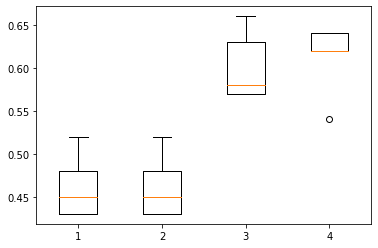

In [36]:
## Accuracy Plot
from matplotlib.pyplot import boxplot

box_plot = plt.subplots(1,1)
box_fig, box_ax = box_plot
box_ax.boxplot(accuracy_scores)
#box_ax.set_xticklabels(feature_names)

for x in range(1,len(entropy_feature_names)+1):
    
    print(str(x) + ': '+  str(entropy_feature_names[x - 1]))
    



1: new_motif_entropy
2: new_discord_entropy
3: motif_entropy
4: discord_entropy


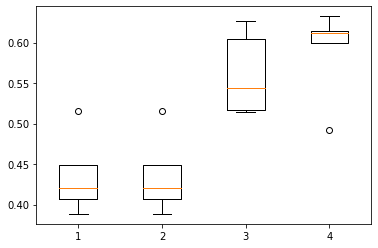

In [37]:
## F Plot
from matplotlib.pyplot import boxplot

box_plot = plt.subplots(1,1)
box_fig, box_ax = box_plot
box_ax.boxplot(f1_scores)
#box_ax.set_xticklabels(feature_names)

for x in range(1,len(entropy_feature_names)+1):
    
    print(str(x) + ': '+  str(entropy_feature_names[x - 1]))

